In [4]:
import os

from PIL import Image, ImageFilter
import sys, glob

import numpy as np
import pandas as pd
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
import lasagne
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
from lasagne import layers
from lasagne.updates import nesterov_momentum, adagrad
from nolearn.lasagne import NeuralNet
import cPickle as pickle
import theano
from IPython.display import display

from lasagne import layers
from nolearn.lasagne import NeuralNet
from PIL import Image, ImageFilter
from nolearn.lasagne import BatchIterator
from PIL import Image, ImageDraw, ImageFont



FTRAIN = '/home/lao/detectKeypoint/dataHelenScale/train/'
FTEST = '/home/lao/detectKeypoint/dataHelenScale/test/'

In [5]:
countSampleInTrain = 2000
X = []
i = 0

for j in range(0, countSampleInTrain):
    infile = FTRAIN + str(j) + ".jpg"
    im = Image.open(infile)

    r,g,b = im.split()

    r = list(r.getdata())
    g = list(g.getdata())
    b = list(b.getdata())
    tmp = np.array((r, g, b))
    tmp = tmp.reshape(3, 100, 100)
    X.append(tmp.tolist())

    i = i + 1
    if i == countSampleInTrain:
        break

X = np.array(X)
X = np.divide(X, 255.) 
X = X.astype(np.float16)

df = read_csv(FTRAIN +"res.csv", header = None)
y = df.as_matrix()
lenY = len(y)
for i in range(countSampleInTrain, lenY):
    y = np.delete(y, countSampleInTrain, 0)
    
y = np.divide(y, 50.) 
y = np.subtract(y, 1)
y = y.astype(np.float16)

X, y = shuffle(X, y, random_state=42)

yN = []
pointInSample = [0, 8, 16, 36, 45, 30, 48, 54]
for i in range(0, len(y)):
    tmp = [0] * (len(pointInSample)*2)
    k = 0
    for j in pointInSample:
        tmp[k] = y[i][j * 2]
        tmp[k + 1] = y[i][j * 2 + 1]
        k = k + 2
    yN.append(tmp)
yN = np.array(yN)

KeyboardInterrupt: 

In [ ]:
X.shape

In [ ]:
class AdjustVariable(object):
    def __init__(self, name, start=0.03, stop=0.001):
        self.name = name
        self.start, self.stop = start, stop
        self.ls = None

    def __call__(self, nn, train_history):
        if self.ls is None:
            self.ls = np.linspace(self.start, self.stop, nn.max_epochs)

        epoch = train_history[-1]['epoch']
        new_value = float32(self.ls[epoch - 1])
        getattr(nn, self.name).set_value(new_value)
def float32(k):
    return np.cast['float32'](k)

class EarlyStopping(object):
    def __init__(self, patience=100):
        self.patience = patience
        self.best_valid = np.inf
        self.best_valid_epoch = 0
        self.best_weights = None

    def __call__(self, nn, train_history):
        current_valid = train_history[-1]['valid_loss']
        current_epoch = train_history[-1]['epoch']
        if current_valid < self.best_valid:
            self.best_valid = current_valid
            self.best_valid_epoch = current_epoch
            self.best_weights = nn.get_all_params_values()
        elif self.best_valid_epoch + self.patience < current_epoch:
            print("Early stopping.")
            print("Best valid loss was {:.6f} at epoch {}.".format(
                self.best_valid, self.best_valid_epoch))
            nn.load_params_from(self.best_weights)
            raise StopIteration()

In [ ]:
net1 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('dropout1', layers.DropoutLayer),  # !
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('dropout2', layers.DropoutLayer),  # !
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('dropout3', layers.DropoutLayer),  # !
        ('hidden4', layers.DenseLayer),
        ('dropout4', layers.DropoutLayer),  # !
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 3, 100, 100),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    dropout1_p=0.1,  # !
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    dropout2_p=0.2,  # !
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    dropout3_p=0.3,  # !
    hidden4_num_units=500,
    dropout4_p=0.5,  # !
    hidden5_num_units=500,

    output_num_units=len(pointInSample) * 2,
    output_nonlinearity=None,

    update=nesterov_momentum,
    
    update_learning_rate=theano.shared(float32(0.03)),
    update_momentum=theano.shared(float32(0.9)),

    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999),
        EarlyStopping(patience=100),
        ],
    
    batch_iterator_train=BatchIterator(batch_size=10),
    regression=True,
    max_epochs=800,
    verbose=1,
    eval_size=0.1
    )
'''

net1 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('dropout1', layers.DropoutLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('dropout2', layers.DropoutLayer),
        ('hidden4', layers.DenseLayer),
        ('dropout3', layers.DropoutLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 3, 100, 100),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),

    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),

    dropout1_p=0.1,
    dropout2_p=0.3,
    dropout3_p=0.5,
    hidden4_num_units=100,

    hidden5_num_units=100,
    #output_num_units=2,
    #output_num_units=136,
    output_num_units=len(pointInSample) * 2,
    output_nonlinearity=None,

    
    update_learning_rate=0.01,
    update_momentum=0.9,
    batch_iterator_train=BatchIterator(batch_size=10),
    regression=True,
    max_epochs=200,
    verbose=1,
    eval_size=0.1
    )
'''
'''
net1 = NeuralNet(
    layers=[  # three layers: one hidden layer
        ('input', layers.InputLayer),
        ('hidden', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    # layer parameters:
    input_shape=(None, 3, 100, 100),  # 96x96 input pixels per batch
    hidden_num_units=100,  # number of units in hidden layer
    output_nonlinearity=None,  # output layer uses identity function
    output_num_units=2,  # 30 target values

    # optimization method:
    update=nesterov_momentum,
    update_learning_rate=0.01,
    update_momentum=0.9,

    regression=True,  # flag to indicate we're dealing with regression problem
    max_epochs=15,  # we want to train this many epochs
    verbose=1,
    )
'''
net1.fit(X, yN)

In [ ]:
print "end"
net1

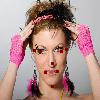

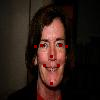

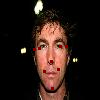

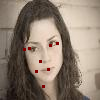

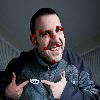

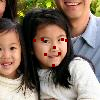

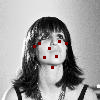

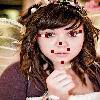

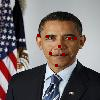

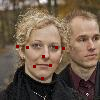

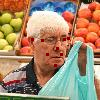

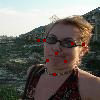

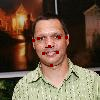

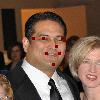

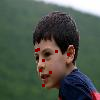

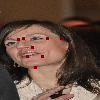

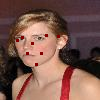

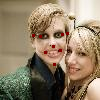

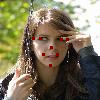

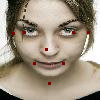

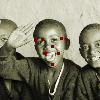

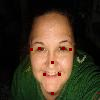

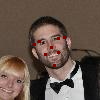

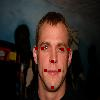

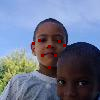

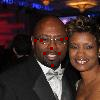

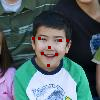

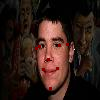

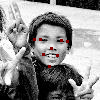

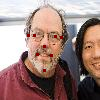

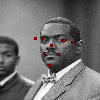

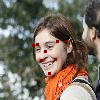

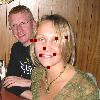

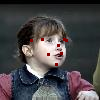

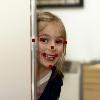

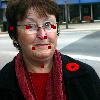

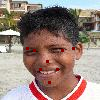

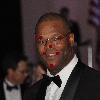

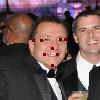

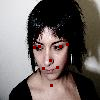

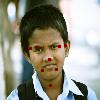

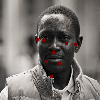

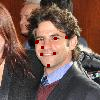

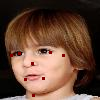

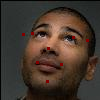

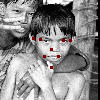

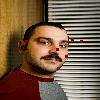

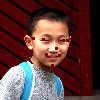

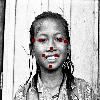

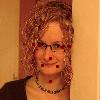

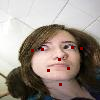

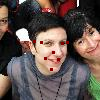

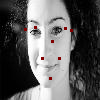

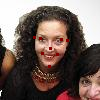

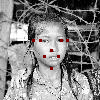

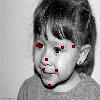

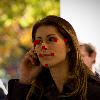

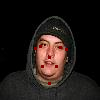

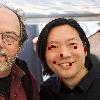

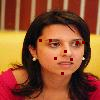

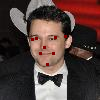

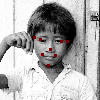

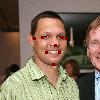

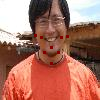

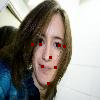

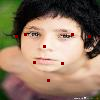

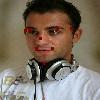

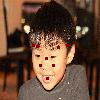

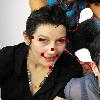

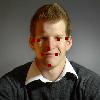

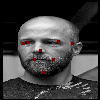

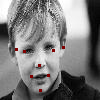

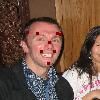

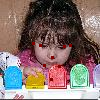

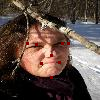

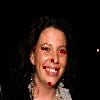

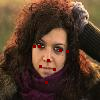

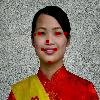

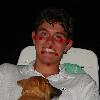

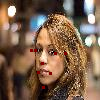

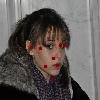

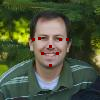

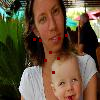

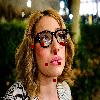

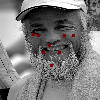

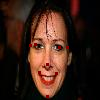

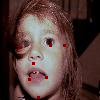

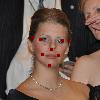

In [21]:
for i in range(0,100):
    X = []
    infile =  FTEST +str(i)+".jpg"
    im = Image.open(infile)
    r,g,b = im.split()

    r = list(r.getdata())
    g = list(g.getdata())
    b = list(b.getdata())
    tmp = np.array((r, g, b))
    tmp = tmp.reshape(3, 100, 100)
    X.append(tmp.tolist())


    X = np.array(X)
    X = np.divide(X, 255.) 
    X = X.astype(np.float16)



    pred = net1.predict(X)
    pred = np.subtract(pred, -1)
    pred = np.multiply(pred, 50)


    pred = pred.reshape(len(pred[0]) / 2, 2)
 

    from PIL import Image, ImageDraw, ImageFont

    fnt = ImageFont.truetype('/home/lao/detectKeypoint/data-latin.ttf', 10)
    
    i = 0
    size = 1
    draw = ImageDraw.Draw(im)
    for i in range(0, len(pred)):
        bbox =  (pred[i][0] - size, pred[i][1] - size, 
                 pred[i][0] + size, pred[i][1] + size)
        draw.ellipse(bbox, fill=128)
        #draw.text((pred[i][0], pred[i][1]), str(i), font=fnt, fill=(255,255,255,128))
    display(im)

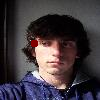

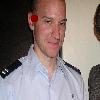

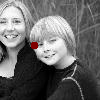

In [11]:
for i in range(184,187):
    X = []
    infile =  infile = "/home/lao/detectKeypoint/dataHelenScale/train/"+str(i)+".jpg"
    im = Image.open(infile)
    r,g,b = im.split()

    r = list(r.getdata())
    g = list(g.getdata())
    b = list(b.getdata())
    tmp = np.array((r, g, b))
    tmp = tmp.reshape(3, 100, 100)
    X.append(tmp.tolist())


    X = np.array(X)
    X = np.divide(X, 255.) 
    X = X.astype(np.float16)



    pred = net1.predict(X)
    pred = pred[0]
    pred = np.subtract(pred, -1)
    pred = np.multiply(pred, 50)


    from PIL import Image, ImageDraw, ImageFont

    fnt = ImageFont.truetype('/home/lao/detectKeypoint/data-latin.ttf', 10)
    im = im.resize((100,100), Image.ANTIALIAS)
    i = 0
    size = 3
    draw = ImageDraw.Draw(im)

    bbox =  (pred[0] - size, pred[1] - size, 
             pred[0] + size, pred[1] + size)
    draw.ellipse(bbox, fill=128)
    #draw.text((pred[i][0], pred[i][1]), str(i), font=fnt, fill=(255,255,255,128))
    display(im)

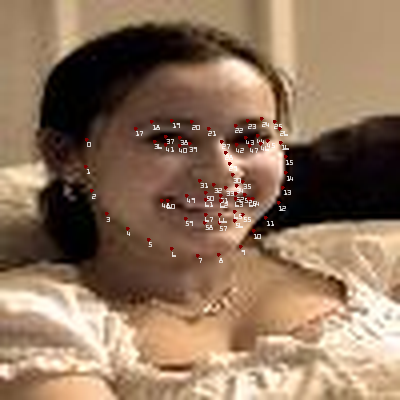

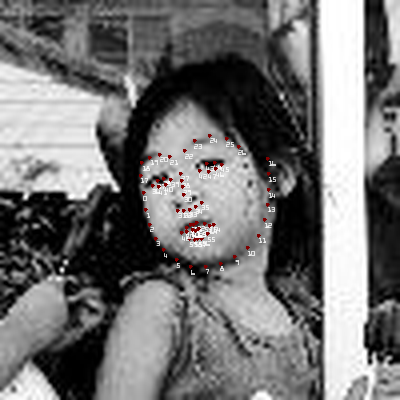

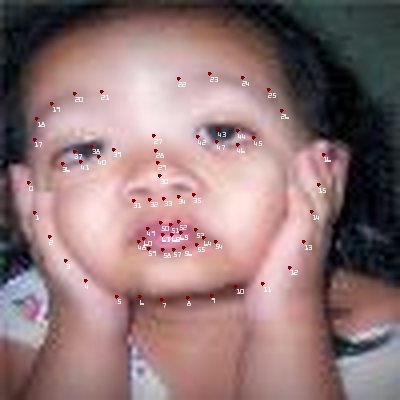

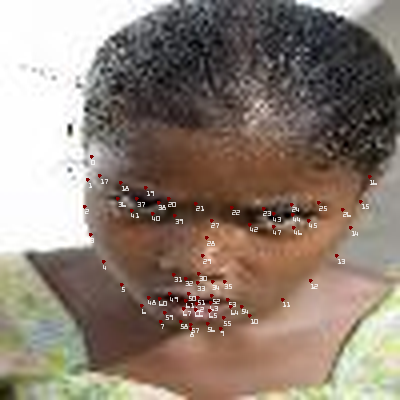

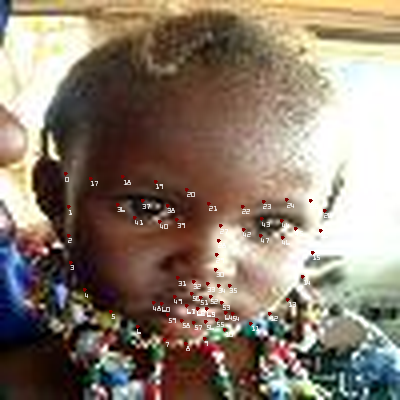

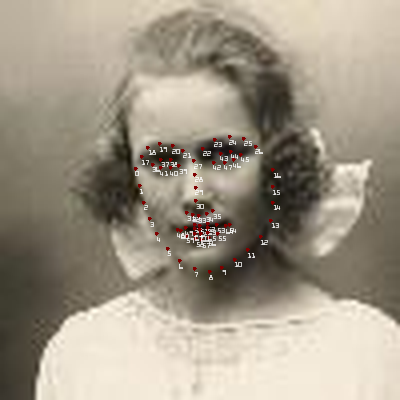

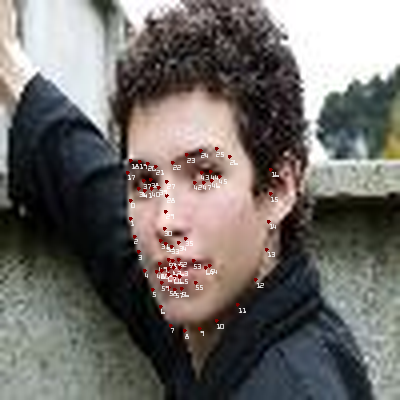

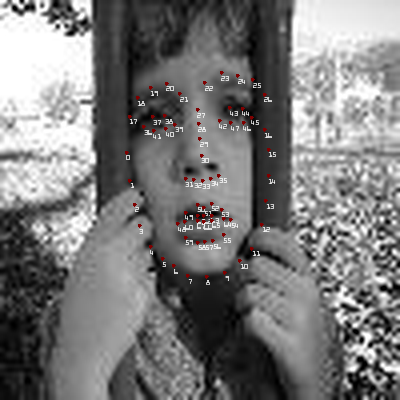

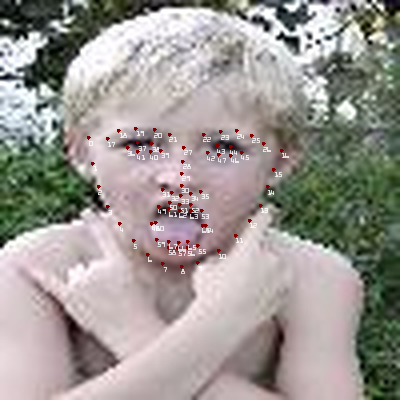

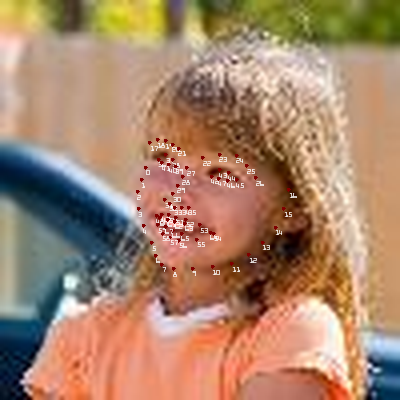

In [5]:
countShow = 10
for i in range(0,countShow):
    infile =  infile = FTRAIN+str(i)+".jpg"
    im = Image.open(infile)
    

    fnt = ImageFont.truetype('/home/lao/detectKeypoint/data-latin.ttf', 8)
    im = im.resize((400,400), Image.ANTIALIAS)
    size = 1.5
    
    df = read_csv(FTRAIN +"res.csv", header = None)
    y = df.as_matrix()
    lenY = len(y)
    for j in range(countShow, lenY):
        y = np.delete(y, countShow, 0)
   
    yTmp = y[i][:]
    
    yTmp = np.subtract(yTmp, -1)
    yTmp = np.multiply(yTmp, 4.) 

    yTmp = yTmp.astype(np.float16)
    yTmp = np.array(yTmp)
    yTmp = yTmp.reshape(68,2)
    
    draw = ImageDraw.Draw(im)
    for j in range(0, 68):
        bbox =  (yTmp[j][0] - size, yTmp[j][1] - size, 
                 yTmp[j][0] + size, yTmp[j][1] + size)
        draw.ellipse(bbox, fill=128)
        draw.text((yTmp[j][0], yTmp[j][1]), str(j), font=fnt, fill=(255,255,255,128))
    display(im)
    [0, 8, 16, 36, 45, 30, 48, 54]

--- 0.00364017486572 seconds ---


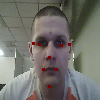

--- 0.00330281257629 seconds ---


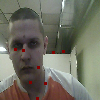

--- 0.00391578674316 seconds ---


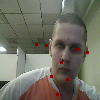

--- 0.00661587715149 seconds ---


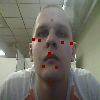

--- 0.00663185119629 seconds ---


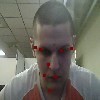

--- 0.00412797927856 seconds ---


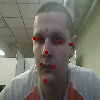

--- 0.00385308265686 seconds ---


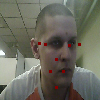

In [9]:
import time
for i in range(0, 7):
    X = []
    infile =  "/home/lao/detectKeypoint/I/"+str(i)+".jpg"
    im = Image.open(infile)
    im = im.resize((100, 100), Image.NEAREST)
    r,g,b = im.split()

    r = list(r.getdata())
    g = list(g.getdata())
    b = list(b.getdata())
    tmp = np.array((r, g, b))
    tmp = tmp.reshape(3, 100, 100)
    X.append(tmp.tolist())


    X = np.array(X)
    X = np.divide(X, 255.) 
    X = X.astype(np.float16)


    start_time = time.time()
    pred = net1.predict(X)
    print("--- %s seconds ---" % (time.time() - start_time))

    pred = np.subtract(pred, -1)
    pred = np.multiply(pred, 50)


    pred = pred.reshape(len(pred[0]) / 2, 2)


    from PIL import Image, ImageDraw, ImageFont

    fnt = ImageFont.truetype('/home/lao/detectKeypoint/data-latin.ttf', 10)

    i = 0
    size = 1
    draw = ImageDraw.Draw(im)
    for i in range(0, len(pred)):
        bbox =  (pred[i][0] - size, pred[i][1] - size, 
                 pred[i][0] + size, pred[i][1] + size)
        draw.ellipse(bbox, fill=128)
        #draw.text((pred[i][0], pred[i][1]), str(i), font=fnt, fill=(255,255,255,128))
    display(im)

In [23]:
import cPickle as pickle
with open('net1.pickle', 'wb') as f:
    pickle.dump(net1, f, -1)

In [4]:
from cv2 import *
# Initialize the camera
capture = CaptureFromCAM(0)  # 0 -> index of camera
if capture:     # Camera initialized without any errors
   NamedWindow("cam-test",CV_WINDOW_AUTOSIZE)
   f = QueryFrame(capture)     # capture the frame
   if f:
       ShowImage("cam-test",f)
       WaitKey(0)
DestroyWindow("cam-test")

NameError: name 'CaptureFromCAM' is not defined

In [7]:
def LoadNet():
    with open('net1.pickle', 'rb') as f:
        return pickle.load(f)

In [168]:
net1 = LoadNet()

  input             	(None, 3, 100, 100) 	produces   30000 outputs
  conv1             	(None, 32, 98, 98)  	produces  307328 outputs
  pool1             	(None, 32, 49, 49)  	produces   76832 outputs
  dropout1          	(None, 32, 49, 49)  	produces   76832 outputs
  conv2             	(None, 64, 48, 48)  	produces  147456 outputs
  pool2             	(None, 64, 24, 24)  	produces   36864 outputs
  dropout2          	(None, 64, 24, 24)  	produces   36864 outputs
  conv3             	(None, 128, 23, 23) 	produces   67712 outputs
  pool3             	(None, 128, 12, 12) 	produces   18432 outputs
  dropout3          	(None, 128, 12, 12) 	produces   18432 outputs
  hidden4           	(None, 500)         	produces     500 outputs
  dropout4          	(None, 500)         	produces     500 outputs
  hidden5           	(None, 500)         	produces     500 outputs
  output            	(None, 16)          	produces      16 outputs


In [44]:
import sys
sys.path.append('/home/lao/release/lib/')
import numpy as np
import cv2

cap = cv2.VideoCapture(0)

width = 100
height = 100

ret, frame = cap.read()

# Our operations on the frame come here
im = cv2.cvtColor(frame, cv2.COLOR_BGRA2BGR)
#imResize = cv2.resize(im,(width, height))
#imResize = np.divide(imResize, 255.) 
#imResize = imResize.astype(np.float16)

X = np.rollaxis(imResize, 2)

cv2.imshow('Image', im)


# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()


error: /home/lao/opencv/modules/videoio/src/cap_gstreamer.cpp:832: error: (-2) GStreamer: unable to start pipeline
 in function cvCaptureFromCAM_GStreamer


In [24]:
print np.rollaxis(imResize, 2).reshape(3, width, height).shape

imResize = np.rollaxis(imResize, 2).reshape(3, width, height)

(3, 100, 100)


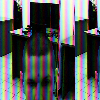

In [25]:
from scipy.misc import toimage
toimage(imResize)

In [33]:
im = Image.fromarray(im)

In [42]:
cap.release()
cv2.destroyAllWindows()